In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.decomposition import NMF
import spacy
import itertools

In [13]:
%load_ext watermark
%watermark -v -n -m -p numpy,sklearn,spacy,pandas,seaborn

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

numpy  : 1.23.5
sklearn: 1.2.0
spacy  : 3.2.1
pandas : 1.4.3
seaborn: 0.12.2

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [105]:
test = pd.read_csv(r'data\BBC News Test.csv')
train = pd.read_csv(r'data\BBC News Train.csv')

# Inspect, Visualize and Clean the Data [15 pts]

## Exploratory Data Analysis (EDA) 

In [106]:
# Look at a sample text 
train.sample(1)['Text'].values

array(['nintendo adds media playing to ds nintendo is releasing an adapter for its ds handheld console so it can play music and video.  the add-on for the ds means people can download tv programmes  film clips or mp3 files to the adaptor and then play them back while on the move. the release of the media add-on is an attempt by the japanese games giant to protect its dominance of the handheld gaming market. nintendo said the media adapter will be available from february in japan.  the nintendo ds is the successor to the hugely successful gameboy handheld game console and went on sale in japan on 2 december. the ds has two screens  one of which is touch sensitive  and also has on-board a short-range wireless link that lets people play against each other.  the launch of the media adapter  and the attempt to broaden the appeal of the device  is widely seen as a response to the unveiling of the sony psp which was built as a multi-purpose media player and game gadget from the start. sony is

Looking at the number of categories shows that there aren't any obvious undersampled ones

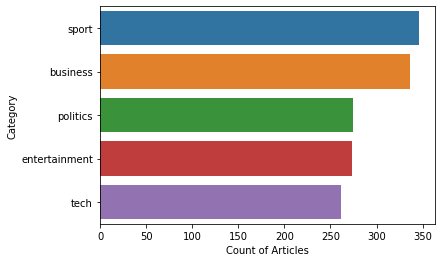

In [107]:
sns.barplot(data=train['Category'].value_counts().to_frame().reset_index(),
            x='Category',
            y='index')
plt.ylabel('Category')
plt.xlabel('Count of Articles')
plt.show()

Further looking at the distribution of word count for categories

In [108]:
train['NumberOfWords'] = train['Text'].str.split().apply(len)

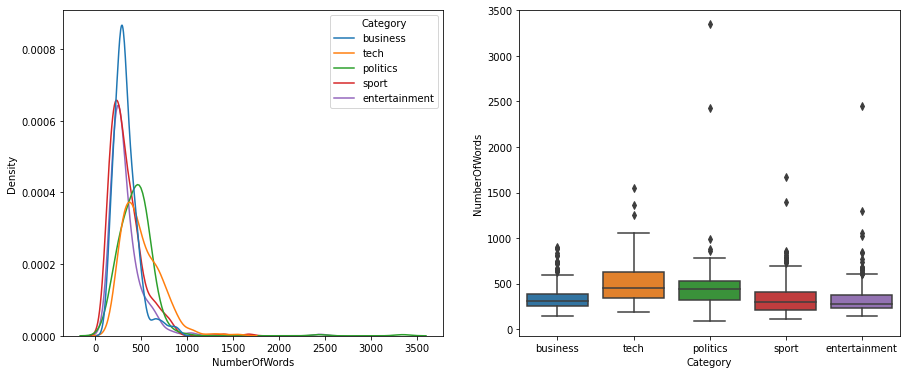

In [109]:
figs, axs = plt.subplots(ncols=2,
                        figsize=(15,6))

g1 = sns.kdeplot(data=train,
        x='NumberOfWords',
        hue='Category',
           ax=axs[0])

g2 = sns.boxplot(data=train,
            x='Category',
            y='NumberOfWords',
           ax=axs[1])

The text length for all categories is around the same range. Some select articles in the 'politics' category seem to be quite long (>2000 words). We can look at them individually to make sure they aren't erroneous. 

In [110]:
train.sort_values('NumberOfWords', ascending=False).head(5)['Text']

1057    minimum wage increased to £5.05 the minimum wa...
454     roundabout continues nostalgia trip the new bi...
1258    kilroy launches  veritas  party ex-bbc chat sh...
364     all black magic: new zealand rugby playing col...
120     apple laptop is  greatest gadget  the apple po...
Name: Text, dtype: object

We do see some stop words that need to be removed, which should be a part of our pre-processing step.

# Building and training models [35 pts]

## Unsupervised Model (NMF)

Before we build our model, we need to do some additional data cleaning and text feature engineering. We'll use the SpaCy library for this.

### Lemmatize and remove stop words using spacy

Some stop words such as 'the', 'if' etc do not provide any classification value, these can be removed along with numbers and punctuation text.

In [111]:
#Load a medium trained model
nlp = spacy.load("en_core_web_md")

In [112]:
def cleaner(note):
    """Remove stop words, punctuations, convert words into lemma_"""
    doc = nlp(note)
    return (" ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.like_num]))

In [113]:
# Might take a while to run this (around 1.5 mins)
train['Text'] = train['Text'].astype(str).apply(cleaner)

To generate our text document, we first get word counts and then calculate their tf-dif (term frequency-inverse document frequency) that will be passed onto our model. This is an important step because tf-dif helps capture relevant words that do not appear frequently throughout the document. 

In [114]:
counter = CountVectorizer()
bag = counter.fit_transform(train['Text'].values)

In [115]:
# Bag contains a sparse matix of all document, word combinations as a 1-gram model (broken off by single words)
bag.toarray().shape

(1490, 18778)

In [116]:
# Apply tf-idf technique to weight down frequent words appearing in all docs
tfidf_vec = TfidfTransformer(use_idf=True,
                             norm='l2', # Apply l2 normalization 
                             smooth_idf=True) # Assigns zero weights to terms occuring in all dosc

In [117]:
tfidf_run = tfidf_vec.fit_transform(bag)

We can use grid search for tf-idf and NMF parameters to tune the model, for this project we only did some ad-hoc changes and went with an NMF model using kullback-leibler beta_loss

|Parameter | Accuracy |
| --------- | --------|
|beta_loss = frobenius, solver = cd | 0.9201 |
|beta_loss = frobenius, solver = mu | 0.9154 |
|beta_loss = kullback-leibler, solver = mu | 0.9423 |

In [118]:
# Fit a NMF model on the tf-dif values
nmf = NMF(solver='mu',
          n_components=5, # The number of topics we want
          beta_loss='kullback-leibler', # 
          random_state=42)
nmf.fit(tfidf_run)

NMF(beta_loss='kullback-leibler', n_components=5, random_state=42, solver='mu')

In [119]:
# We can get the max position of the transform using argmax
predicted_labels = nmf.transform(tfidf_run).argmax(axis=1)
predicted_labels

array([4, 4, 4, ..., 4, 2, 2], dtype=int64)

In [120]:
def label_permute_compare(y_actual, y_pred, n=5):
    """
    Args:
        y_actual -> pd.Series with categories as text
        y_pred -> np.array with predictions
        n -> Number of permutations in y_pred 
    Returns: 
        Predicted labels, accuracy score
    """
    all_scores = []
    actual_labels = y_actual.unique().tolist()
    
    # Generate permutations to check against
    for perm in itertools.permutations((0, 1, 2, 3, 4), 5):
        remap_dict = dict(zip(actual_labels, perm))
        # Change the values in the prediction
        y_actual_coded = y_actual.replace(remap_dict)
        acc = accuracy_score(y_actual_coded, y_pred)           
        all_scores.append([perm, acc])
    
    best_score = sorted(all_scores, key=lambda x:x[1])[-1]
    
    return best_score, actual_labels

In [121]:
# We pass the max values into a function to predict the labels
label_predictions = label_permute_compare(train['Category'], predicted_labels)

# Print the results
print(f'Labels are -> {label_predictions[0][0]} for {label_predictions[1]}\
\n Accuracy -> {label_predictions[0][1]}')

Labels are -> (4, 2, 1, 0, 3) for ['business', 'tech', 'politics', 'sport', 'entertainment']
 Accuracy -> 0.9422818791946309


In [122]:
label_category_mapping = dict(zip(label_predictions[0][0], label_predictions[1]))
label_category_mapping

{4: 'business', 2: 'tech', 1: 'politics', 0: 'sport', 3: 'entertainment'}

In [123]:
train_results = train.copy().assign(Predictions=list(map(label_category_mapping.get, predicted_labels)))
train_results.sample(5)

,ArticleId,Text,Category,NumberOfWords,Predictions
165,378,tory lib dem hit list liberal democrats ai...,politics,303,politics
1342,1197,original exorcist screen original version horr...,entertainment,302,entertainment
522,1007,winemaker reject foster s offer australian win...,business,302,business
595,331,yangtze electric s profit double yangtze elect...,business,280,business
1364,189,mcconnell drunk remark row scotland s mini...,politics,520,politics


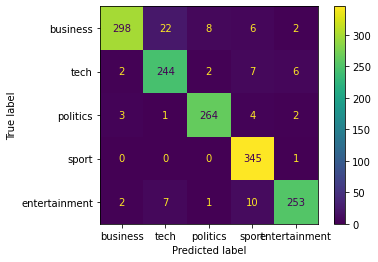

In [124]:
cf_m = ConfusionMatrixDisplay(confusion_matrix(train_results['Category'], 
                                               train_results['Predictions'],
                                               labels=label_predictions[1]),
                                               display_labels=label_predictions[1])
cf_m.plot()

### Test Predictions

We need to reapply the pre-processing steps we applied to the training dataset.

In [125]:
# Spacy to clean text, this might take some time
test['Text'] = test['Text'].astype(str).apply(cleaner)

In [126]:
bag_test = counter.transform(test['Text'].values)

In [127]:
tfidf_test_run = tfidf_vec.transform(bag_test)

In [128]:
# We can get the max position of the transform using argmax
test_predicted_labels = nmf.transform(tfidf_test_run).argmax(axis=1)

In [129]:
test_results = test.copy().assign(Category=list(map(label_category_mapping.get, test_predicted_labels)))
test_results.sample(5)

,ArticleId,Text,Category
288,798,kenyan school turn handheld mbita point primar...,tech
550,448,weak data buffet french economy batch downbeat...,business
595,927,microsoft make anti piracy microsoft say clamp...,tech
177,2125,tate lyle boss bag award tate lyle s chief exe...,business
174,1889,abba queen enter music rich list woman abba mu...,entertainment


In [130]:
test_results[['ArticleId', 'Category']].to_csv(r'predictions\unsupervised_predictions.csv', index=False)

The unsupervised test public score was **0.92789**

#  Compare with supervised learning [30 pts]

## Supervised Model

We will now predict the categories using a supervised model (KNN)

In [131]:
from sklearn.neighbors import KNeighborsClassifier

In [132]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(tfidf_run.toarray(), train['Category'])

KNeighborsClassifier()

In [133]:
category_predictions = knn.predict(tfidf_run.toarray())

In [134]:
accuracy_score(train['Category'], category_predictions)  

0.9557046979865772

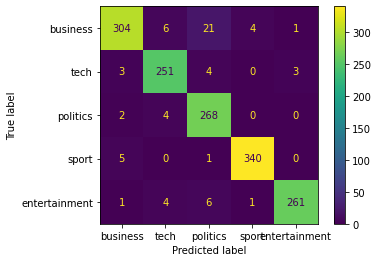

In [135]:
cf_m_sup = ConfusionMatrixDisplay(confusion_matrix(train['Category'], 
                                                   category_predictions,
                                                   labels=label_predictions[1]),
                                                   display_labels=label_predictions[1])
cf_m_sup.plot()

### Tests Predictions

In [136]:
test_category_predictions = knn.predict(tfidf_test_run.toarray())

In [137]:
test_results_supervised = test.copy().assign(Category=test_category_predictions)
test_results_supervised.sample(5)

,ArticleId,Text,Category
348,737,o sullivan keep powder dry gun glory ultimate ...,sport
628,524,tory leader clear work scottish conservati...,politics
478,1304,gamer buy $ virtual land year old gamer spend ...,tech
179,1274,million miss net uk s population internet ac...,tech
160,1477,dollar slide ahead new year dollar hit new rec...,business


In [138]:
test_results_supervised[['ArticleId', 'Category']].to_csv(r'predictions\supervised_predictions.csv', index=False)

The unsupervised test public score was **0.94829**

### Check with only a sample of data

In [139]:
train_50 = train.groupby('Category', group_keys=False).apply(lambda x: x.sample(frac=.5)).copy()

In [140]:
# Check that the fractions are maintained
train_50['Category'].value_counts(normalize=True)

sport            0.232527
business         0.225806
politics         0.184140
entertainment    0.182796
tech             0.174731
Name: Category, dtype: float64

The supervised model performed better than the unsupervised model for both the training and test dataset, it could've also been tuned to perform better. 

When ran with only 50% of the data by replacing all trained values with train_50, this trend continued. The results are as follows:

<br>The training, testing scores for unsupervised -> **0.7728, 0.840**</br>
<br>The training, testing scores for supervised -> **0.9529, 0.9306**</br>

# References


<br>Competition https://kaggle.com/competitions/learn-ai-bbc</br>
<br>Sklearn Library https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html</br>
<br>Spacy https://spacy.io/usage/spacy-101</br>
<br>ML Book https://github.com/rasbt/machine-learning-book</br>